# Time Series Kneightbors Regressor Algorithm

This algorithm is used to forecast FOREX prices for the USDCAD pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data, backtest
import ta

In [48]:
# Initiate bound between MetaTrader5 and Python
mt5.initialize()

True

In [50]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDCAD", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,1.1648,1.1655,1.1646,1.1647,309,40,0
2015-01-02 09:00:00,1.1648,1.1658,1.1647,1.1648,441,40,0
2015-01-02 10:00:00,1.1647,1.1653,1.1642,1.1647,631,40,0
2015-01-02 11:00:00,1.1648,1.1659,1.1642,1.1659,443,40,0
2015-01-02 12:00:00,1.1658,1.1666,1.1655,1.1655,341,40,0


In [52]:
# Drop "spread" and "real_volume" columns and remane columns "tick_volumne" to only "volumne"
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,1.1648,1.1655,1.1646,1.1647,309
2015-01-02 09:00:00,1.1648,1.1658,1.1647,1.1648,441
2015-01-02 10:00:00,1.1647,1.1653,1.1642,1.1647,631
2015-01-02 11:00:00,1.1648,1.1659,1.1642,1.1659,443
2015-01-02 12:00:00,1.1658,1.1666,1.1655,1.1655,341


## Feature Engineering 
**Creating new input variables from raw data**

In [55]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,1.1647,NaN
2015-01-02 09:00:00,1.1648,0.000086
2015-01-02 10:00:00,1.1647,-0.000086
2015-01-02 11:00:00,1.1659,0.001030
2015-01-02 12:00:00,1.1655,-0.000343


In [57]:
# New DataFrame with all indications from "ta" library and shifting them by one row
df_indicators = ta.add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True).shift(1)
df_indicators

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,1.16480,1.16550,1.16460,1.16470,309.0,-240.333333,309.0,-0.777778,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.164700,0.000000,0.000000,0.000000
2015-01-02 10:00:00,1.16480,1.16580,1.16470,1.16480,441.0,-601.151515,750.0,-0.801535,0.044100,0.049887,...,0.000685,0.000137,0.000548,3.303215,0.660643,2.642572,1.164744,0.008586,0.008586,0.008586
2015-01-02 11:00:00,1.16470,1.16530,1.16420,1.16470,631.0,-658.515152,119.0,-0.476839,0.028786,-0.087163,...,0.000529,0.000215,0.000313,9.890616,2.506637,7.383978,1.164725,-0.008585,-0.008586,0.000000
2015-01-02 12:00:00,1.16480,1.16590,1.16420,1.16590,443.0,-215.515152,562.0,-0.118155,0.100616,0.115124,...,0.008619,0.001896,0.006723,10.497761,4.104862,6.392898,1.165235,0.103031,0.102978,0.103031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-22 10:00:00,1.35845,1.35857,1.35786,1.35816,783.0,-441062.677670,2266953.0,-0.006332,-0.082647,-0.037178,...,-0.052927,-0.057609,0.004682,-27.393718,-17.402796,-9.990923,1.359005,-0.023556,-0.023559,16.610286
2024-08-22 11:00:00,1.35817,1.35823,1.35743,1.35754,1994.0,-442508.327670,2264959.0,-0.038442,-0.247452,-0.015446,...,-0.056148,-0.057317,0.001169,-18.875234,-17.697283,-1.177951,1.358765,-0.045650,-0.045660,16.557053
2024-08-22 12:00:00,1.35754,1.35773,1.35708,1.35771,1471.0,-441127.850747,2266430.0,-0.038154,-0.176377,-0.018780,...,-0.057034,-0.057260,0.000226,-15.597062,-17.277239,1.680177,1.358688,0.012523,0.012522,16.571649


In [58]:
# Identifying columns with all zero values to avoid interference during model training
zero_columns_list = df_indicators.columns[(df_indicators == 0).all(axis=0)].tolist()
zero_columns_list

[]

In [85]:
# Concatenating both dataframes and drop the close column (which wasn't shifted) from df_copy
new_df = pd.concat((df_indicators, df_copy["pct_change"]), axis=1)
new_df.dropna(inplace=True)

# Making sure all columns are shown
pd.set_option('display.max_columns', None)

new_df.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,pct_change
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 09:00:00,1.1648,1.1655,1.1646,1.1647,309.0,-240.333333,309.0,-0.777778,0.000000,0.000000,0.000000,0.000000,1.164933,50.000000,1000.000000,1.164700,1.164700,1.164700,0.000000,0.000000,0.0,0.0,1.164933,1.165833,1.164033,0.154515,0.370370,0.0,0.0,1.1646,1.1655,1.16505,0.077273,0.111111,0.0,0.0,0.000000,0.000000,0.000000,1.164700,1.164700,1.164700,1.164700,0.000000,0.000000,0.000000,-11.179900,1.000000,0.146670,-111.845190,-111.845190,0.000000,1.16505,1.16505,1.16505,1.16505,0.0,0.0,0.0,0.0,0.000000,1.311368,1.311338,0.0,0.0,0.0,1.1642,1.1655,0.0,0.0,100.000000,0.0,0.0,0.0,0.000000,0.000000,11.111111,11.111111,-88.888889,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.164700,0.000000,0.000000,0.000000,0.000086
2015-01-02 10:00:00,1.1648,1.1658,1.1647,1.1648,441.0,-601.151515,750.0,-0.801535,0.044100,0.049887,0.049887,0.037864,1.165031,100.000000,1000.000000,1.164750,1.164850,1.164650,0.017171,0.750000,0.0,0.0,1.165017,1.166017,1.164017,0.171671,0.391667,0.0,0.0,1.1646,1.1658,1.16520,0.103026,0.166667,0.0,0.0,0.000008,0.000002,0.000006,1.164750,1.164750,1.164715,1.164707,0.008115,0.005410,0.002705,0.000017,2.035242,0.146620,-111.807062,-111.826126,0.019064,1.16520,1.16520,1.16520,1.16520,0.0,0.0,0.0,0.0,66.666667,1.311368,1.311338,4.0,0.0,4.0,1.1642,1.1655,0.0,0.0,100.000000,0.0,0.0,0.0,100.000000,5.000000,16.666667,13.888889,-83.333333,0.0,0.0,0.000685,0.000137,0.000548,3.303215,0.660643,2.642572,1.164744,0.008586,0.008586,0.008586,-0.000086
2015-01-02 11:00:00,1.1647,1.1653,1.1642,1.1647,631.0,-658.515152,119.0,-0.476839,0.028786,-0.087163,-0.018638,-0.016309,1.164895,41.145682,1000.000000,1.164733,1.164828,1.164639,0.016189,0.323223,0.0,0.0,1.164922,1.165956,1.163889,0.177408,0.392473,0.0,0.0,1.1642,1.1658,1.16500,0.137370,0.312500,0.0,0.0,0.000006,0.000003,0.000004,1.164733,1.164733,1.164713,1.164707,0.012083,0.016111,-0.004028,0.000027,3.090846,0.146637,-111.819772,-111.824008,0.004236,1.16500,1.16500,1.16500,1.16500,0.0,0.0,0.0,0.0,-100.000000,1.311368,1.311338,4.0,8.0,-4.0,1.1642,1.1655,0.0,1.0,48.148148,0.0,0.0,0.0,97.802198,19.354839,31.250000,19.675926,-68.750000,0.0,0.0,0.000529,0.000215,0.000313,9.890616,2.506637,7.383978,1.164725,-0.008585,-0.008586,0.000000,0.001030
2015-01-02 12:00:00,1.1648,1.1659,1.1642,1.1659,443.0,-215.515152,562.0,-0.118155,0.100616,0.115124,0.025949,0.440118,1.165002,58.359923,1001.030308,1.165025,1.166039,1.164011,0.174015,0.931606,0.0,0.0,1.165025,1.166225,1.163825,0.206004,0.864583,0.0,0.0,1.1642,1.1659,1.16505,0.145920,1.000000,0.0,0.0,0.000100,0.00002

## Implementing Machine Learning

In [71]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = new_df.iloc[:,:-1]
y = new_df["pct_change"]

X_train, y_train, X_test, y_test = data.split_data(X, y)

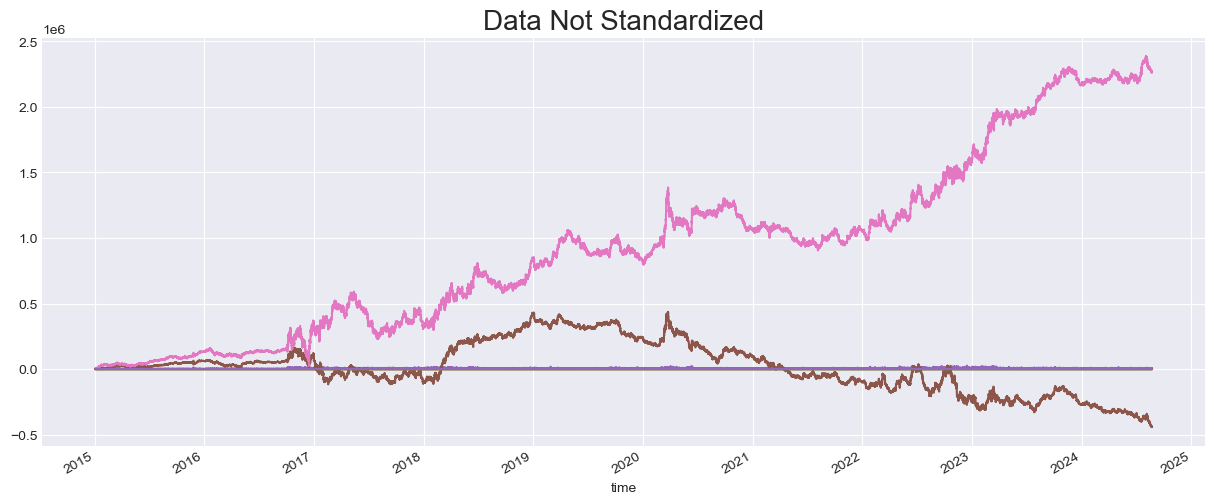

In [83]:
# Plotting features before standardization to visualize their unequal scales (plot shows only the first 15 indicators)
X.iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Data Not Standardized", fontsize=20)
plt.show()

### Standardizing The Data

In [88]:
from sklearn.preprocessing import StandardScaler

In [90]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

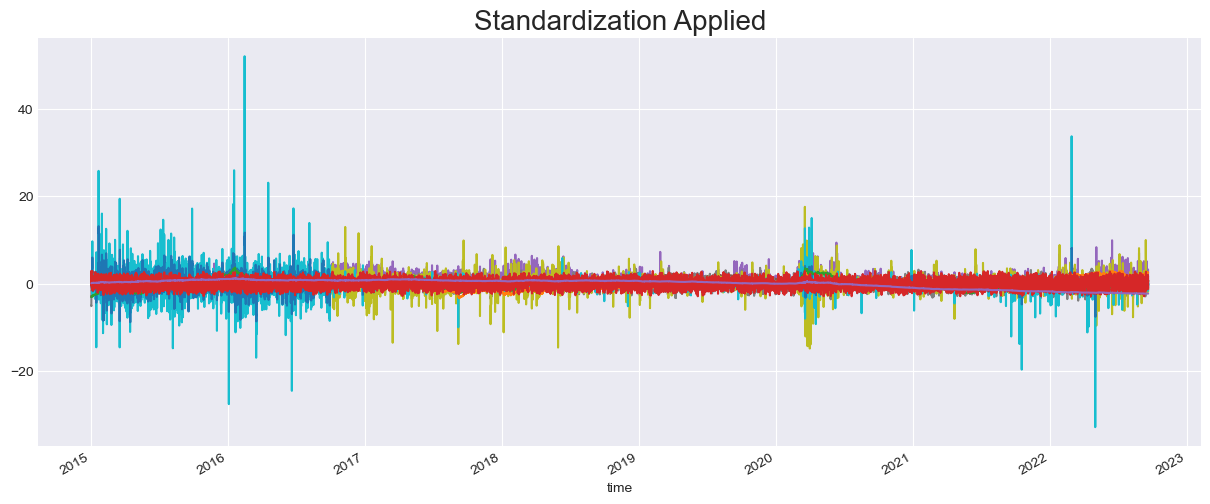

In [92]:
# Plotting the standardized data for the indicators (plot shows only form the first 15 indicatos)
pd.DataFrame(X_train_scaled, index=X_train.index, columns=X.columns).iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Standardization Applied", fontsize=20);

### Training the K Neightbors Regression Model

In [110]:
from sklearn.neighbors import KNeighborsRegressor

In [112]:
knb = KNeighborsRegressor()

# Training the Model
knb.fit(X_train_scaled, y_train)

# Making predictions
predictions = knb.predict(X_test_scaled)

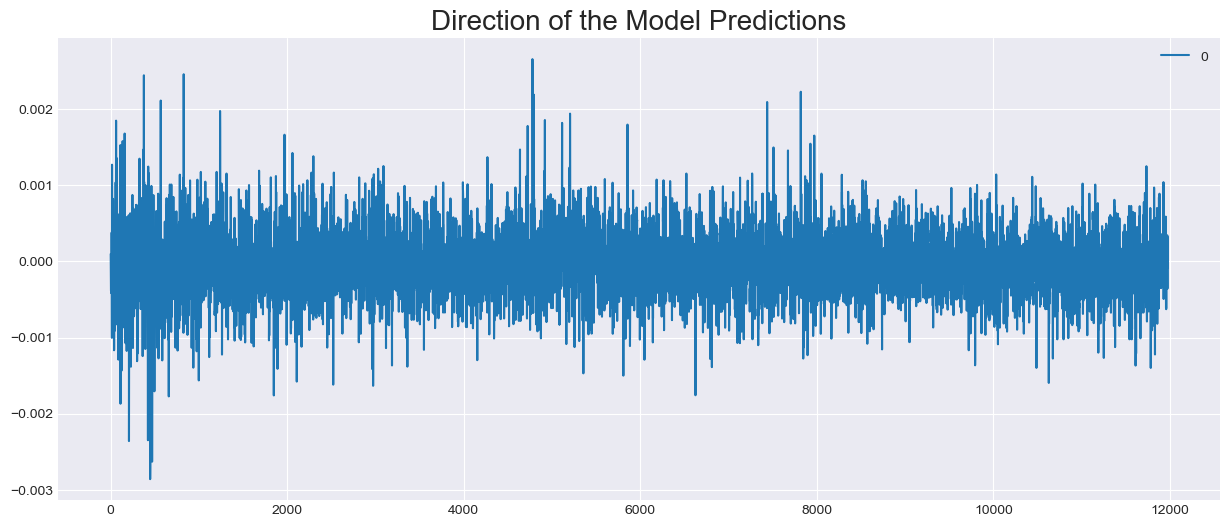

In [114]:
# Plotting to visualize predictions to make sure go in both directions
pd.DataFrame(predictions).plot(figsize=(15,6))
plt.title("Direction of the Model Predictions", fontsize=20);

**Compute Returns for Kneightbors Model**

In [121]:
# Check the docstring of the "compute_strategy_returns" function from the backtest.py file
returns = backtest.compute_strategy_returns(y_test, predictions)
returns

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2022-09-20 03:00:00,0.000506,0.000097,1.0,1.0,0.000506
2022-09-20 04:00:00,0.000747,-0.000110,1.0,-1.0,-0.000747
2022-09-20 05:00:00,-0.000762,-0.000062,-1.0,-1.0,0.000762
2022-09-20 06:00:00,-0.000159,-0.000384,-1.0,-1.0,0.000159
2022-09-20 07:00:00,0.000498,-0.000384,1.0,-1.0,-0.000498
...,...,...,...,...,...
2024-08-22 10:00:00,-0.000456,-0.000027,-1.0,-1.0,0.000456
2024-08-22 11:00:00,0.000125,0.000343,1.0,1.0,0.000125
2024-08-22 12:00:00,0.000074,-0.000351,1.0,-1.0,-0.000074
